<a href="https://colab.research.google.com/github/yutongxie58/Diabetes_Classification_using_MLP/blob/main/DiabetesMLP2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Keras TF - Code Along Diabetes Classification Project

We will explore a diabetes classification task with Keras API for TF 2.0

## The Data

We will be using data from a Kaggle data set:

https://www.kaggle.com/datasets/mathchi/diabetes-data-set

#### Feature Columns
    
* Pregnancies: Number of times pregnant
* Glucose: Plasma glucose concentration a 2 hours in an oral glucose tolerance test
* BloodPressure: Diastolic blood pressure (mm Hg)
* SkinThickness: Triceps skin fold thickness (mm)
* Insulin: 2-Hour serum insulin (mu U/ml)
* BMI: Body mass index (weight in kg/(height in m)^2)
* DiabetesPedigreeFunction: Diabetes pedigree function
* Age: Age (years)
* Outcome: Class variable (0 or 1)

#### Summary Statistics

* Number of Instances: 768
* Number of Attributes: 8 plus class
* Missing Attribute Values: Yes
* Class Distribution: (class value 1 is interpreted as "tested positive for
diabetes")

In [ ]:
# !pip install skompiler

In [ ]:
# Libraries
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import roc_auc_score,roc_curve
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn import tree
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.ensemble import GradientBoostingClassifier
# from xgboost import XGBClassifier
# from lightgbm import LGBMClassifier
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.metrics import mean_squared_error
# from skompiler import skompile
from warnings import filterwarnings
filterwarnings('ignore')

# DATASET

In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.width', 500)

diabetes = pd.read_csv("/content/diabetes.csv")
df = diabetes.copy()
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.600,0.627,50,1
1,1,85,66,29,0,26.600,0.351,31,0
2,8,183,64,0,0,23.300,0.672,32,1
3,1,89,66,23,94,28.100,0.167,21,0
4,0,137,40,35,168,43.100,2.288,33,1


In [ ]:
def check_df(dataframe, head = 5):
    print("############## Shape ##############")
    print(dataframe.shape)
    print("############## Types ##############")
    print(dataframe.dtypes)
    print("############## Head ##############")
    print(dataframe.head(head))
    print("############## Tail ##############")
    print(dataframe.tail(head))
    print("############## NA ##############")
    print(dataframe.isnull().sum())
    print("############## Quantiles ##############")
    print(dataframe.describe([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

check_df(df)

############## Shape ##############
(768, 9)
############## Types ##############
Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object
############## Head ##############
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin    BMI  DiabetesPedigreeFunction  Age  Outcome
0            6      148             72             35        0 33.600                     0.627   50        1
1            1       85             66             29        0 26.600                     0.351   31        0
2            8      183             64              0        0 23.300                     0.672   32        1
3            1       89             66             23       94 28.100                     0.167   21      

# DATA PRE-PROCESSING

In [ ]:
# Let's make variables's names smaller

df.columns = [col.lower() for col in df.columns]
df.head()

,pregnancies,glucose,bloodpressure,skinthickness,insulin,bmi,diabetespedigreefunction,age,outcome
0,6,148,72,35,0,33.600,0.627,50,1
1,1,85,66,29,0,26.600,0.351,31,0
2,8,183,64,0,0,23.300,0.672,32,1
3,1,89,66,23,94,28.100,0.167,21,0
4,0,137,40,35,168,43.100,2.288,33,1


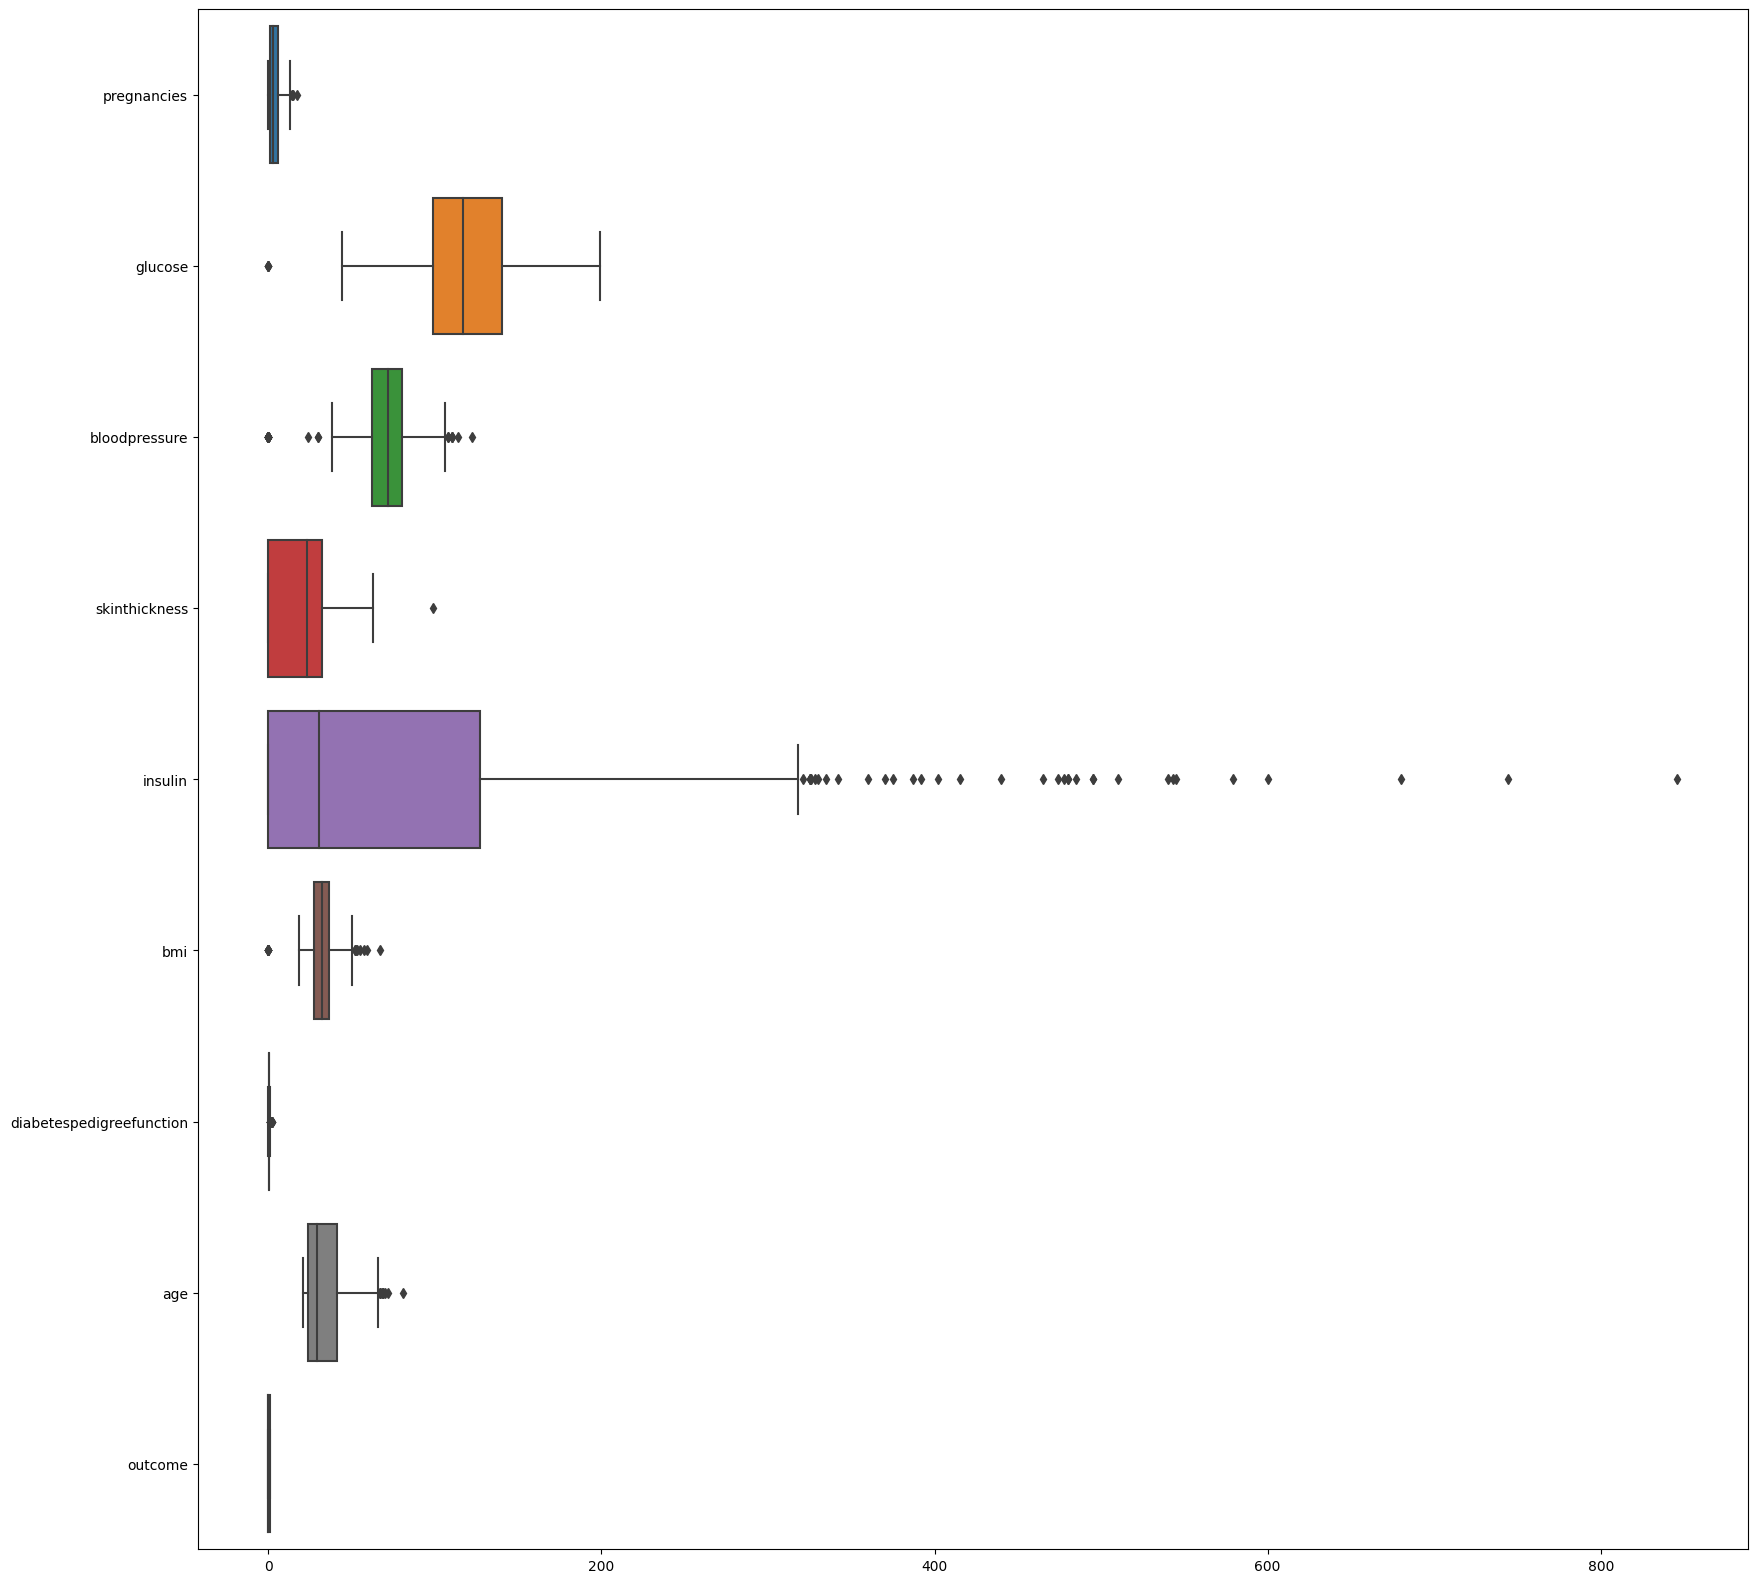

In [ ]:
# Checking Outliers

f, ax = plt.subplots(figsize=(20,20))
fig = sns.boxplot(data=df, orient="h")

<Axes: xlabel='outcome', ylabel='count'>

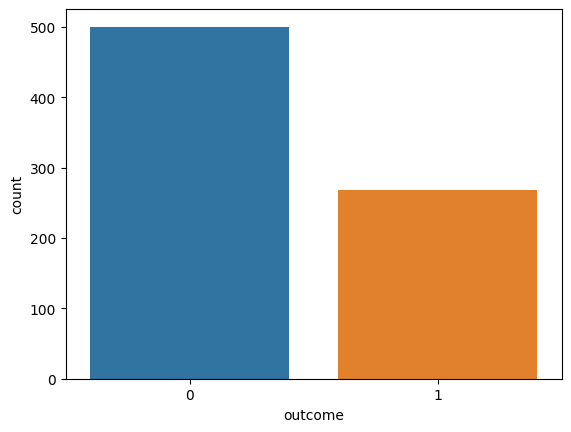

In [ ]:
sns.countplot(x='outcome',data=df)

<Axes: >

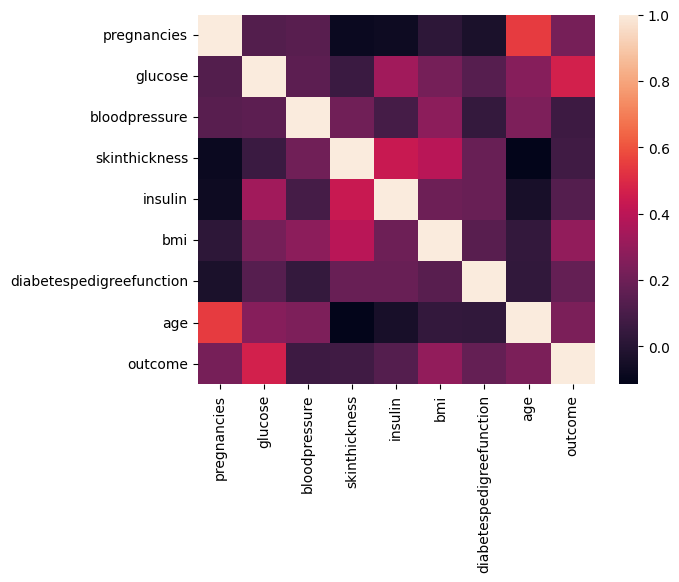

In [ ]:
# let's see the corr graphs of the variables
corr = df.corr()

sns.heatmap(corr,
         xticklabels=corr.columns,
         yticklabels=corr.columns)

<Axes: >

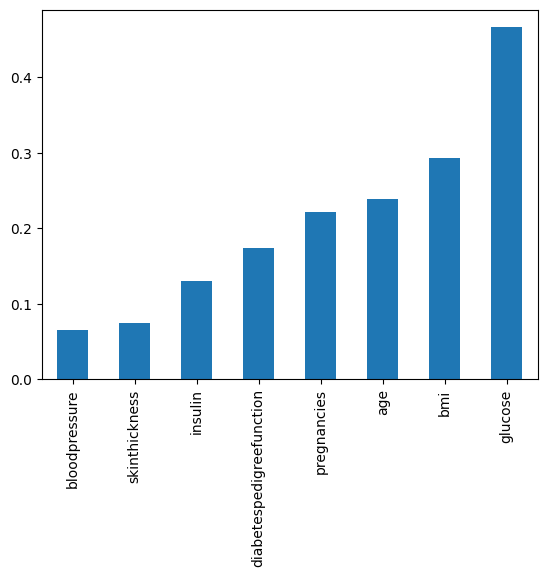

In [ ]:
df.corr()['outcome'][:-1].sort_values().plot(kind='bar')

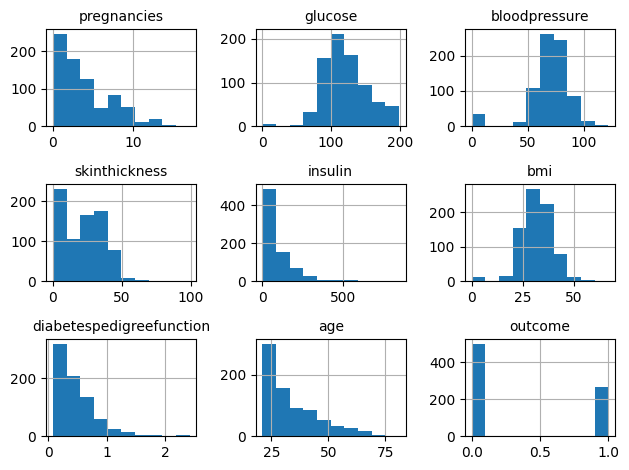

In [ ]:
# Create histograms for all columns in the DataFrame
df.hist()

# Iterate through each subplot to set the font size for the titles
for ax in plt.gcf().get_axes():
    ax.set_title(ax.get_title(), fontsize=10)  # Set the font size to 8

# Add tight layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

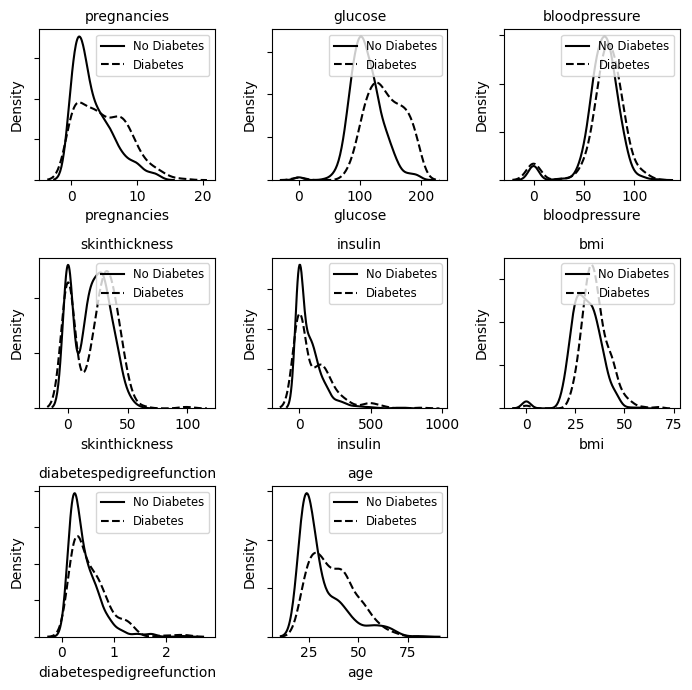

In [ ]:
# Create a subplot of 3 x 3
fig, axes = plt.subplots(3, 3, figsize=(7, 7))

# Flatten the axes array for easy indexing
axes = axes.flatten()

# Plot a density plot for each variable
for idx, col in enumerate(df.columns):
    # Skip the 9th subplot (bottom right) since there are only 8 plots
    if idx == 8:
        axes[idx].set_visible(False)
        continue
    
    ax = axes[idx]
    ax.yaxis.set_ticklabels([])
    sns.kdeplot(df.loc[df.outcome == 0][col], ls='-', color='black', label='No Diabetes', ax=ax)
    sns.kdeplot(df.loc[df.outcome == 1][col], ls='--', color='black', label='Diabetes', ax=ax)
    ax.set_title(col,fontsize=10)
    # Move the legend to the upper right corner, Set the legend font size to 'small'
    ax.legend(loc='upper right', fontsize='small')  
# Add tight layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    """

   Returns the names of categorical, numeric and categorical but cardinal variables in the data set.
   Note Categorical variables include categorical variables with numeric appearance.

    Parameters
    ------
        dataframe: dataframe
                Dataframe to get variable names
        cat_th: int, optional
                class threshold for numeric but categorical variables
        car_th: int, optinal
                class threshold for categorical but cardinal variables

    Returns
    ------
        cat_cols: list
                Categorical variable list
        num_cols: list
                Numeric variable list
        cat_but_car: list
                List of cardinal variables with categorical view

    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grab_col_names(df))


    Notes
    ------
        cat_cols + num_cols + cat_but_car = total number of variables
        
        The sum of 3 lists with return equals the total number of variables: cat_cols + num_cols + cat_but_car = number of variables

    """

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car

cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 768
Variables: 9
cat_cols: 1
num_cols: 8
cat_but_car: 0
num_but_cat: 1


In [ ]:
# Outliers

def outlier_thresholds(dataframe, col_name, q1=0.15, q3=0.85):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + interquantile_range
    low_limit = quartile1 - 1.3 * interquantile_range
    return low_limit, up_limit

In [ ]:
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

In [ ]:
def grab_outliers(dataframe, col_name, index=False):
    low, up = outlier_thresholds(dataframe, col_name)

    if dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].shape[0] > 10:
        print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].head())
    else:
        print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))])

    if index:
        outlier_index = dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].index
        return outlier_index
    
    for col in df.columns:
        print(col, grab_outliers(df,col))

In [ ]:
def replace_with_thresholds(dataframe, variable):
        low_limit, up_limit = outlier_thresholds(dataframe, variable)
        dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
        dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

for col in num_cols:
        print(replace_with_thresholds(df, col))

None
None
None
None
None
None
None
None


In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
pregnancies,768.000,3.842,3.360,0.000,1.000,3.000,6.000,15.000
glucose,768.000,120.937,31.816,6.500,99.000,117.000,140.250,199.000
bloodpressure,768.000,70.188,15.673,24.200,62.000,72.000,80.000,110.000
skinthickness,768.000,20.504,15.817,0.000,0.000,23.000,32.000,74.000
insulin,768.000,75.132,97.656,0.000,0.000,30.500,127.250,359.800
bmi,768.000,32.047,7.454,5.968,27.300,32.000,36.600,53.785
diabetespedigreefunction,768.000,0.463,0.296,0.078,0.244,0.372,0.626,1.321
age,768.000,33.224,11.700,21.000,24.000,29.000,41.000,70.000
outcome,768.000,0.349,0.477,0.000,0.000,0.000,1.000,1.000


In [ ]:
# There are no missing observations in the dataset
# but for variables such as Glucose, Insulin, etc., observation units containing a value of 0 may represent a missing value.

variables = ["skinthickness", "insulin"]
df[variables] = df[variables].replace(0,np.NaN)
df.isnull().sum()

pregnancies                   0
glucose                       0
bloodpressure                 0
skinthickness               227
insulin                     374
bmi                           0
diabetespedigreefunction      0
age                           0
outcome                       0
dtype: int64

In [ ]:
# Handle to missing value
df["skinthickness"].fillna(df.groupby("outcome")["skinthickness"].transform("mean"), inplace=True)
df["insulin"].fillna(df.groupby('outcome')["insulin"].transform("mean"), inplace=True)
df.isnull().sum()

pregnancies                 0
glucose                     0
bloodpressure               0
skinthickness               0
insulin                     0
bmi                         0
diabetespedigreefunction    0
age                         0
outcome                     0
dtype: int64

# FEATURE ENGINEERING

In [ ]:
df.loc[(df['age'] >= 21) & (df['age'] <= 50), 'sex_cat'] = 'mature'
df.loc[(df['age'] > 50), 'sex_cat'] = 'elder'

In [ ]:
df["new_bmi"] = pd.cut(x=df['bmi'], bins=[0, 18.5, 24.9, 29.9, 35, 40, 100],labels=["underweight", "healthy", "overweight",
                                                                                  "obese1", "obese2", "obese3"])

In [ ]:
df.loc[(df["glucose"] < 140), 'glucose_cat'] = "normal"
df.loc[(df["glucose"] >= 140), 'glucose_cat'] = "at_risk"

In [ ]:
df.loc[(df['glucose'] < 140) & (df["age"] <= 50), "age_gul_cat"] = "normal_mature"
df.loc[(df['glucose'] < 140) & (df["age"] > 50), "age_gul_cat"] = "normal_elder"
df.loc[(df["glucose"] >= 140)& (df['age'] <= 50), "age_gul_cat"] = "at_risk_mature"
df.loc[(df["glucose"] >= 140)& (df['age'] > 50), "age_gul_cat"] = "at_risk_elder"

In [ ]:
df.loc[(df["insulin"] < 126), "insul_level"] = "is_normal"
df.loc[(df["insulin"] >= 126), "insul_level"] = "not_normal"

In [ ]:
df.loc[(df["insulin"] < 126) & (df["age"] <= 50), "age_insul_level"] = "is_normal_mature"
df.loc[(df["insulin"] < 126) & (df["age"] > 50), "age_insul_level"] = "is_normal_elder"
df.loc[(df["insulin"] >= 126) & (df["age"] <= 50), "age_insul_level"] = "not_normal_mature"
df.loc[(df["insulin"] >= 126) & (df["age"] > 50), "age_insul_level"] = "not_normal_elder"

In [ ]:
df["gulucos_insulin"] = df["glucose"]*df["insulin"]
df.head()

,pregnancies,glucose,bloodpressure,skinthickness,insulin,bmi,diabetespedigreefunction,age,outcome,sex_cat,new_bmi,glucose_cat,age_gul_cat,insul_level,age_insul_level,gulucos_insulin
0,6.000,148.000,72.000,35.000,189.692,33.600,0.627,50.000,1,mature,obese1,at_risk,at_risk_mature,not_normal,not_normal_mature,28074.462
1,1.000,85.000,66.000,29.000,125.155,26.600,0.351,31.000,0,mature,overweight,normal,normal_mature,is_normal,is_normal_mature,10638.201
2,8.000,183.000,64.000,32.861,189.692,23.300,0.672,32.000,1,mature,healthy,at_risk,at_risk_mature,not_normal,not_normal_mature,34713.692
3,1.000,89.000,66.000,23.000,94.000,28.100,0.167,21.000,0,mature,overweight,normal,normal_mature,is_normal,is_normal_mature,8366.000
4,0.000,137.000,40.000,35.000,168.000,43.100,1.321,33.000,1,mature,obese3,normal,normal_mature,not_normal,not_normal_mature,23016.000


In [ ]:
# Checking again grab_col_names function
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 768
Variables: 16
cat_cols: 7
num_cols: 9
cat_but_car: 0
num_but_cat: 2


In [ ]:
def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("##########################################")
    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show()

for col in cat_cols:
    cat_summary(df, col)

        sex_cat  Ratio
mature      687 89.453
elder        81 10.547
##########################################
         glucose_cat  Ratio
normal           571 74.349
at_risk          197 25.651
##########################################
                age_gul_cat  Ratio
normal_mature           529 68.880
at_risk_mature          158 20.573
normal_elder             42  5.469
at_risk_elder            39  5.078
##########################################
            insul_level  Ratio
is_normal           434 56.510
not_normal          334 43.490
##########################################
                   age_insul_level  Ratio
is_normal_mature               397 51.693
not_normal_mature              290 37.760
not_normal_elder                44  5.729
is_normal_elder                 37  4.818
##########################################
   outcome  Ratio
0      500 65.104
1      268 34.896
##########################################
             new_bmi  Ratio
obese1           228 29.688
o

In [ ]:
# Encoding

le = LabelEncoder()

def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe

binary_cols = [col for col in df.columns if df[col].dtypes == "O" and df[col].nunique() == 2]
print(binary_cols)

['sex_cat', 'glucose_cat', 'insul_level']


In [ ]:
df = label_encoder(df, "sex_cat")
df = label_encoder(df, 'glucose_cat')
df = label_encoder(df,'insul_level')

In [ ]:
def one_hot_encoder(dataframe, categorical_cols, drop_first=True):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

ohe_cols = [col for col in df.columns if 12 >= df[col].nunique() > 2]

df = one_hot_encoder(df, ohe_cols, drop_first=True)
df.head()

,pregnancies,glucose,bloodpressure,skinthickness,insulin,bmi,diabetespedigreefunction,age,outcome,sex_cat,glucose_cat,insul_level,gulucos_insulin,new_bmi_healthy,new_bmi_overweight,new_bmi_obese1,new_bmi_obese2,new_bmi_obese3,age_gul_cat_at_risk_mature,age_gul_cat_normal_elder,age_gul_cat_normal_mature,age_insul_level_is_normal_mature,age_insul_level_not_normal_elder,age_insul_level_not_normal_mature
0,6.000,148.000,72.000,35.000,189.692,33.600,0.627,50.000,1,1,0,1,28074.462,0,0,1,0,0,1,0,0,0,0,1
1,1.000,85.000,66.000,29.000,125.155,26.600,0.351,31.000,0,1,1,0,10638.201,0,1,0,0,0,0,0,1,1,0,0
2,8.000,183.000,64.000,32.861,189.692,23.300,0.672,32.000,1,1,0,1,34713.692,1,0,0,0,0,1,0,0,0,0,1
3,1.000,89.000,66.000,23.000,94.000,28.100,0.167,21.000,0,1,1,0,8366.000,0,1,0,0,0,0,0,1,1,0,0
4,0.000,137.000,40.000,35.000,168.000,43.100,1.321,33.000,1,1,1,1,23016.000,0,0,0,0,1,0,0,1,0,0,1


In [ ]:
df.head()

,pregnancies,glucose,bloodpressure,skinthickness,insulin,bmi,diabetespedigreefunction,age,outcome,sex_cat,glucose_cat,insul_level,gulucos_insulin,new_bmi_healthy,new_bmi_overweight,new_bmi_obese1,new_bmi_obese2,new_bmi_obese3,age_gul_cat_at_risk_mature,age_gul_cat_normal_elder,age_gul_cat_normal_mature,age_insul_level_is_normal_mature,age_insul_level_not_normal_elder,age_insul_level_not_normal_mature
0,6.000,148.000,72.000,35.000,189.692,33.600,0.627,50.000,1,1,0,1,28074.462,0,0,1,0,0,1,0,0,0,0,1
1,1.000,85.000,66.000,29.000,125.155,26.600,0.351,31.000,0,1,1,0,10638.201,0,1,0,0,0,0,0,1,1,0,0
2,8.000,183.000,64.000,32.861,189.692,23.300,0.672,32.000,1,1,0,1,34713.692,1,0,0,0,0,1,0,0,0,0,1
3,1.000,89.000,66.000,23.000,94.000,28.100,0.167,21.000,0,1,1,0,8366.000,0,1,0,0,0,0,0,1,1,0,0
4,0.000,137.000,40.000,35.000,168.000,43.100,1.321,33.000,1,1,1,1,23016.000,0,0,0,0,1,0,0,1,0,0,1


# MLP MODEL

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 24 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   pregnancies                        768 non-null    float64
 1   glucose                            768 non-null    float64
 2   bloodpressure                      768 non-null    float64
 3   skinthickness                      768 non-null    float64
 4   insulin                            768 non-null    float64
 5   bmi                                768 non-null    float64
 6   diabetespedigreefunction           768 non-null    float64
 7   age                                768 non-null    float64
 8   outcome                            768 non-null    int64  
 9   sex_cat                            768 non-null    int64  
 10  glucose_cat                        768 non-null    int64  
 11  insul_level                        768 non-null    int64  

In [ ]:
X = df.drop('outcome',axis=1).values
y = df['outcome'].values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=101)

In [ ]:
# Now time to future scaling for numeric cols

scaler = MinMaxScaler()

X_train= scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
X_train.shape

(614, 23)

In [ ]:
model = Sequential()

# https://stats.stackexchange.com/questions/181/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-netw

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(1,activation='sigmoid'))

# class_weight = {0: 1, 1: 2}

# For a binary classification problem
model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=35)

In [ ]:
model.fit(x=X_train, 
          y=y_train, 
          batch_size=32,
          epochs=400,
          validation_data=(X_test, y_test), 
          verbose=1,
          callbacks=[early_stop],
          # class_weight=class_weight
          )

Epoch 1/400
20/20 [==============================] - 2s 19ms/step - loss: 0.6576 - accuracy: 0.6091 - val_loss: 0.5881 - val_accuracy: 0.6688
Epoch 2/400
20/20 [==============================] - 0s 6ms/step - loss: 0.5900 - accuracy: 0.6661 - val_loss: 0.4838 - val_accuracy: 0.7727
Epoch 3/400
20/20 [==============================] - 0s 6ms/step - loss: 0.4849 - accuracy: 0.7769 - val_loss: 0.3934 - val_accuracy: 0.8312
Epoch 4/400
20/20 [==============================] - 0s 7ms/step - loss: 0.4223 - accuracy: 0.8160 - val_loss: 0.3677 - val_accuracy: 0.8312
Epoch 5/400
20/20 [==============================] - 0s 4ms/step - loss: 0.4275 - accuracy: 0.8274 - val_loss: 0.3658 - val_accuracy: 0.8442
Epoch 6/400
20/20 [==============================] - 0s 4ms/step - loss: 0.4246 - accuracy: 0.8208 - val_loss: 0.3585 - val_accuracy: 0.8377
Epoch 7/400
20/20 [==============================] - 0s 4ms/step - loss: 0.4094 - accuracy: 0.8339 - val_loss: 0.3503 - val_accuracy: 0.8442
Epoch 8/400


<Axes: >

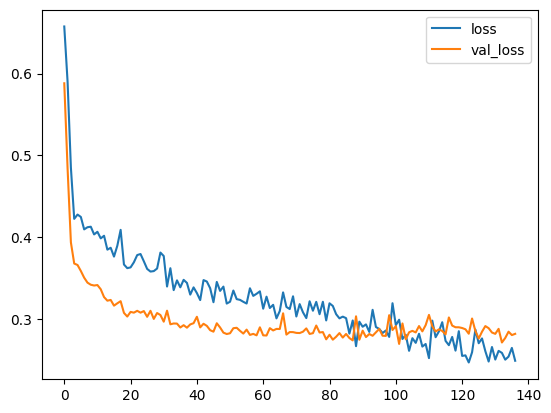

In [ ]:
model_loss = pd.DataFrame(model.history.history)[['loss','val_loss']]
model_loss.plot()

# MODEL EVALUATION

In [ ]:
predictions = (model.predict(X_test) > 0.5)*1

5/5 [==============================] - 0s 3ms/step


In [ ]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.94      0.92      0.93       103
           1       0.85      0.88      0.87        51

    accuracy                           0.91       154
   macro avg       0.89      0.90      0.90       154
weighted avg       0.91      0.91      0.91       154



In [ ]:
print(confusion_matrix(y_test,predictions))

[[95  8]
 [ 6 45]]


5/5 [==============================] - 0s 4ms/step


Text(0, 0.5, 'True Positive Rate')

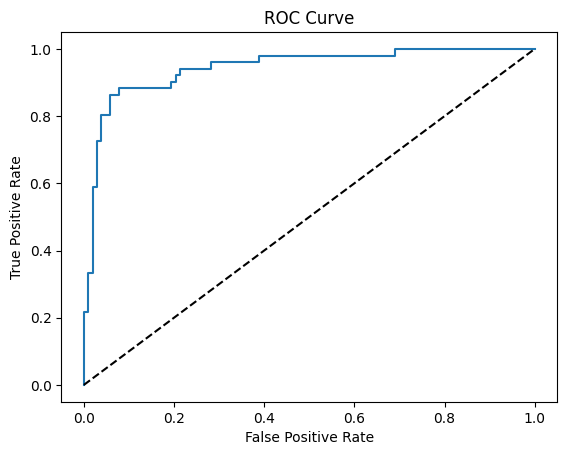

In [ ]:
y_test_pred_probs = model.predict(X_test) 

FPR, TPR, _ = roc_curve(y_test, y_test_pred_probs)

plt.plot(FPR, TPR)
plt.plot([0,1],[0,1],'--', color='black') #diagonal line
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')